In [1]:
import sys
import os
import xarray as xr
import numpy as np
import pandas as pd
from pandas import DataFrame
import geopandas as gpd
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
from matplotlib import pyplot
import rasterio
import datacube
from datacube.utils import geometry 
from datacube.utils.geometry import CRS
from datacube.utils import masking
from datacube.helpers import ga_pq_fuser, write_geotiff
#from digitalearthau.utils import wofs_fuser
sys.path.append('../10_Scripts/')
#import DEAPlotting, DEADataHandling
import warnings
warnings.filterwarnings('ignore', module='datacube')
%load_ext autoreload
%autoreload 2

In [2]:
csv = 'Tantangara.csv'

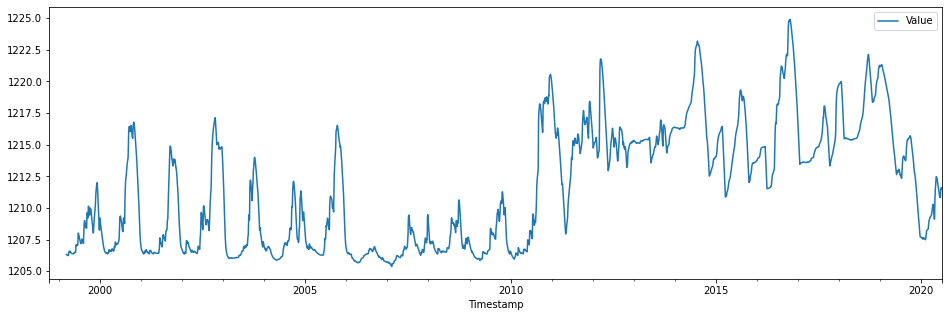

In [3]:
orig_hydrograph = pd.read_csv(csv,
                error_bad_lines = False, skiprows=9, escapechar='#',
                         parse_dates=['Timestamp'], #Tells it this column is date format
                         index_col=('Timestamp'), #Tells it to set Timestamp as the index column
                        date_parser=lambda x: pd.to_datetime(x.rsplit('+', 1)[0])) #turns timestamp into date
orig_hydrograph = orig_hydrograph.drop(columns=['Interpolation Type', 'Quality Code'])
orig_hydrograph.plot(figsize=(16, 5))

In [4]:
orig_hydrograph = orig_hydrograph.dropna()
hydrograph1 = pd.read_csv(csv,
                error_bad_lines = False, skiprows=9, escapechar='#', parse_dates=['Timestamp'])
hydrograph1 = hydrograph1.drop(columns=['Interpolation Type', 'Quality Code'])
hydrograph1 = hydrograph1.dropna()
depth_integers = hydrograph1.Value.astype(np.int64)
depth_integers_list = depth_integers.to_list()
orig_hydrograph['Depth'] = depth_integers_list
orig_hydrograph['Date'] = orig_hydrograph.index
depth_to_area = pd.read_csv('depth_to_area.csv')

/env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [5]:
depth_to_area

,Unnamed: 0,Gauge ID,Name,Depth,Surface Area
0,0,410543,Murrumbidgee River at Tantangara Reservoir,1205,2413125
1,1,410543,Murrumbidgee River at Tantangara Reservoir,1206,2778125
2,2,410543,Murrumbidgee River at Tantangara Reservoir,1207,3143125
3,3,410543,Murrumbidgee River at Tantangara Reservoir,1208,3722500
4,4,410543,Murrumbidgee River at Tantangara Reservoir,1209,4056250
5,5,410543,Murrumbidgee River at Tantangara Reservoir,1210,4576875
6,6,410543,Murrumbidgee River at Tantangara Reservoir,1211,4888125
7,7,410543,Murrumbidgee River at Tantangara Reservoir,1212,5372500
8,8,410543,Murrumbidgee River at Tantangara Reservoir,1213,5885625
9,9,410543,Murrumbidgee River at Tantangara Reservoir,1214,6353125


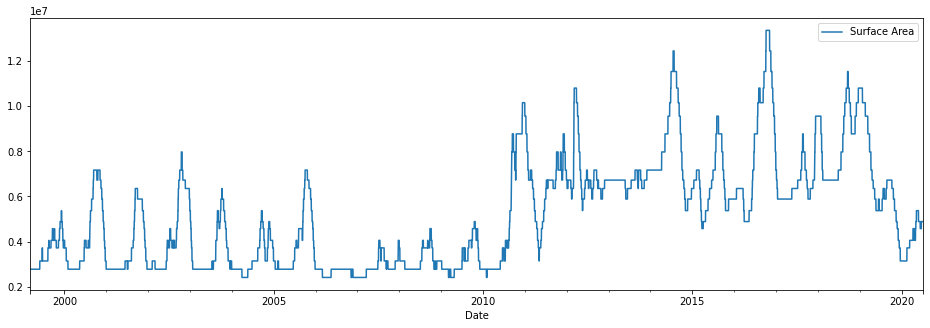

In [6]:
merged = (orig_hydrograph
          .merge(depth_to_area[['Surface Area', 'Depth', 'Name', 'Gauge ID']], on='Depth'))
merged = merged.sort_values(['Date'])
date_surfacearea = merged.set_index(['Date'])
date_surfacearea = date_surfacearea.drop(columns=['Value', 'Depth'])

date_surfacearea.plot(figsize=(16, 5))

In [9]:
merged = (orig_hydrograph
          .merge(depth_to_area[['Surface Area', 'Depth', 'Name', 'Gauge ID']], on='Depth'))
merged = merged.sort_values(['Date'])

surface_area_by_date = merged.drop(columns=['Value', 'Depth'])
surface_area_by_date

,Date,Surface Area,Name,Gauge ID
0,1999-03-09,2778125,Murrumbidgee River at Tantangara Reservoir,410543
1,1999-03-10,2778125,Murrumbidgee River at Tantangara Reservoir,410543
2,1999-03-11,2778125,Murrumbidgee River at Tantangara Reservoir,410543
3,1999-03-12,2778125,Murrumbidgee River at Tantangara Reservoir,410543
4,1999-03-13,2778125,Murrumbidgee River at Tantangara Reservoir,410543
...,...,...,...,...
3829,2020-07-02,4888125,Murrumbidgee River at Tantangara Reservoir,410543
3830,2020-07-03,4888125,Murrumbidgee River at Tantangara Reservoir,410543
3831,2020-07-04,4888125,Murrumbidgee River at Tantangara Reservoir,410543
3832,2020-07-05,4888125,Murrumbidgee River at Tantangara Reservoir,410543


In [10]:
surface_area_by_date.to_csv('surface_area_timeseries.csv')